# **Proyecto Aprendizaje Automático en Series Temporales y Flujos de Datos: Predicción de Calidad del Aire en Madrid**

**Grupo:** 7

**Curso Académico:** 2025-2026

**Autores**:

- *Alejandro Díaz Cuéllar, 100472173*
  
- *Ilias El Hanouch Toudghi, 100472198*
  
- *Diego Navas Sánchez, 100472123*

### *Descripción del Proyecto*

Este proyecto aborda el análisis y pronóstico de series temporales en la predicción de niveles de contaminación atmosférica en la ciudad de Madrid. El objetivo principal es aplicar técnicas avanzadas de aprendizaje automático para series temporales, combinando métodos clásicos y modernos para desarrollar un modelo predictivo robusto que permita anticipar episodios de alta contaminación.

El dataset utilizado proviene del Portal de Datos del Ayuntamiento de Madrid, que incluye mediciones horarias (solo en el año 2025) de diversos contaminantes atmosféricos desde múltiples estaciones de monitoreo distribuidas por la ciudad. El dataset puede encontrarse en el siguiente enlace: 

https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=f3c0f7d512273410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default.

### *Importación de librerías*

Comenzamos importando las librerias necesarias para la ejecución del notebook.

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster, backtesting_sarimax, grid_search_sarimax
from skforecast.recursive import ForecasterRecursive
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

/Users/diegonavas/Desktop/APRENDIZAJE AUTOMÁTICO EN SERIES TEMPORALES Y FLUJOS DE DATOS/ACTIVIDADES CLASE/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **1. Carga y Preparación de los Datos**

En esta primera sección del notebook se realiza la preparación previa tanto de la serie temporal como de las variables exógenas que se emplearán.

### *Estructura del Dataset*

El dataset sigue un formato "wide" característico de datos oficiales de calidad del aire. Según el PDF asociado al conjunto de datos, tenemos la siguiente información acerca de su estructura:

#### Variables de Identificación
- **PROVINCIA**: Código de provincia (28 = Madrid)
- **MUNICIPIO**: Código de municipio
- **ESTACION**: Código identificador de la estación de medición
- **MAGNITUD**: Código del contaminante medido
- **PUNTO_MUESTREO**: Identificador único del punto de muestreo

#### Variables Temporales
- **ANO**: Año de la medición
- **MES**: Mes de la medición (1-12)
- **DIA**: Día del mes (1-31)

#### Variables de Medición
- **H01, H02, ..., H24**: Valores medidos para cada hora del día
- **V01, V02, ..., V24**: Indicadores de validación ('V' = válido, 'N' = no válido)

### *Códigos de Contaminantes*
- **1**: Dióxido de Azufre (SO₂)
- **6**: Monóxido de Carbono (CO)
- **7**: Monóxido de Nitrógeno (NO)
- **8**: Dióxido de Nitrógeno (NO₂)
- **9**: Partículas < 2.5 μm (PM2.5)
- **10**: Partículas < 10 μm (PM10)
- **12**: Óxidos de Nitrógeno (NOₓ)
- **14**: Ozono (O₃)
- **20**: Tolueno
- **30**: Benceno
- **35**: Etilbenceno

### *Preparación de la serie temporal*

Nuestra serie temporal se centrará en el valor de **NO₂** debido a su papel central como contaminante primario y secundario, su toxicidad directa y su conexión con otros contaminantes atmosféricos. Para ello, utilizaremos los valores medidos por una estación de medición concreta (elegimos aleatoriamente la número 57). Además, únicamente se emplearán valores comprendidos entre el 2025-01-01 y el 2025-09-01.

Por lo tanto, en primer lugar, cargamos el dataset, hacemos uso de la función `wide_to_long` para obtener el formato de serie temporal y filtramos los datos a los valores de Dióxido de Nitrógeno, de la estación 57 y que estén en el rango temporal que buscamos.

In [2]:
# Cargar el dataset
df_raw = pd.read_csv('CALIDAD_AIRE_HORARIOS20250913.csv', sep=';')

print(f"\nDimensiones: {df_raw.shape[0]} filas x {df_raw.shape[1]} columnas")
print(f"\nColumnas: {df_raw.columns.tolist()[:10]}...")
df_raw.head()


Dimensiones: 36033 filas x 56 columnas

Columnas: ['PROVINCIA', 'MUNICIPIO', 'ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES', 'DIA', 'H01', 'V01']...


,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,11,12,28079011_12_8,2025,1,1,30.0,V,...,75.0,V,249.0,V,306.0,V,219.0,V,191.0,V
1,28,79,11,12,28079011_12_8,2025,1,2,150.0,V,...,49.0,V,41.0,V,56.0,V,38.0,V,25.0,V
2,28,79,11,12,28079011_12_8,2025,1,3,17.0,V,...,175.0,V,212.0,V,152.0,V,63.0,V,99.0,V
3,28,79,11,12,28079011_12_8,2025,1,4,173.0,V,...,61.0,V,69.0,V,76.0,V,68.0,V,56.0,V
4,28,79,11,12,28079011_12_8,2025,1,5,68.0,V,...,40.0,V,33.0,V,32.0,V,30.0,V,22.0,V


In [3]:
def wide_to_long(df):
    """
    Transforma el dataset de formato wide (una columna por hora)
    a formato long (una fila por medición horaria)
    """

    # Lista para almacenar datos reestructurados
    rows_list = []

    for _, row in df.iterrows():
        for hour in range(24):
            h_col = f'H{str(hour+1).zfill(2)}'
            v_col = f'V{str(hour+1).zfill(2)}'

            # Crear datetime completo
            fecha = pd.Timestamp(
                year=int(row['ANO']),
                month=int(row['MES']),
                day=int(row['DIA']),
                hour=hour
            )

            rows_list.append({
                'datetime': fecha,
                'provincia': row['PROVINCIA'],
                'municipio': row['MUNICIPIO'],
                'estacion': row['ESTACION'],
                'magnitud': row['MAGNITUD'],
                'punto_muestreo': row['PUNTO_MUESTREO'],
                'valor': row[h_col],
                'validacion': row[v_col]
            })

    return pd.DataFrame(rows_list)

In [4]:
# Filtrar datos de NO₂ y de la estacion 57
df_no2 = df_raw[df_raw['MAGNITUD'] == 8]
estacion_principal = 57
df_estacion = df_no2[df_no2['ESTACION'] == estacion_principal]

# Cambia el formato del dataframe
df_estacion = wide_to_long(df_estacion)

# Filtramos unicamente las fechas necesarias
df_estacion['datetime'] = pd.to_datetime(df_estacion['datetime'])
display(df_estacion.head())
df_estacion = df_estacion[df_estacion['datetime'] <= pd.to_datetime('2025-09-01 23:00:00')]
print(f"Rango temporal: {df_estacion['datetime'].min()} a {df_estacion['datetime'].max()}")

,datetime,provincia,municipio,estacion,magnitud,punto_muestreo,valor,validacion
0,2025-01-01 00:00:00,28,79,57,8,28079057_8_8,22.0,V
1,2025-01-01 01:00:00,28,79,57,8,28079057_8_8,22.0,V
2,2025-01-01 02:00:00,28,79,57,8,28079057_8_8,30.0,V
3,2025-01-01 03:00:00,28,79,57,8,28079057_8_8,32.0,V
4,2025-01-01 04:00:00,28,79,57,8,28079057_8_8,23.0,V


Rango temporal: 2025-01-01 00:00:00 a 2025-09-01 23:00:00


Una vez obtenido el dataframe con el formato y con los valores buscados, debemos tratar las mediciones que no son válidas. Para ello, realizamos una filtración de ellas y eliminamos los posibles valores nulos que puedan quedar.

In [5]:
# Filtrar solo datos válidos
df_estacion = df_estacion[df_estacion['validacion'] == 'V']

# Convertir valores a numérico
df_estacion['valor'] = pd.to_numeric(df_estacion['valor'], errors='coerce')

# Eliminar valores nulos
df_estacion = df_estacion.dropna(subset=['valor'])

Como último paso de esta preparación de la serie temporal, comprobamos que ha sido preparada correctamente visualizándola gráficamente.

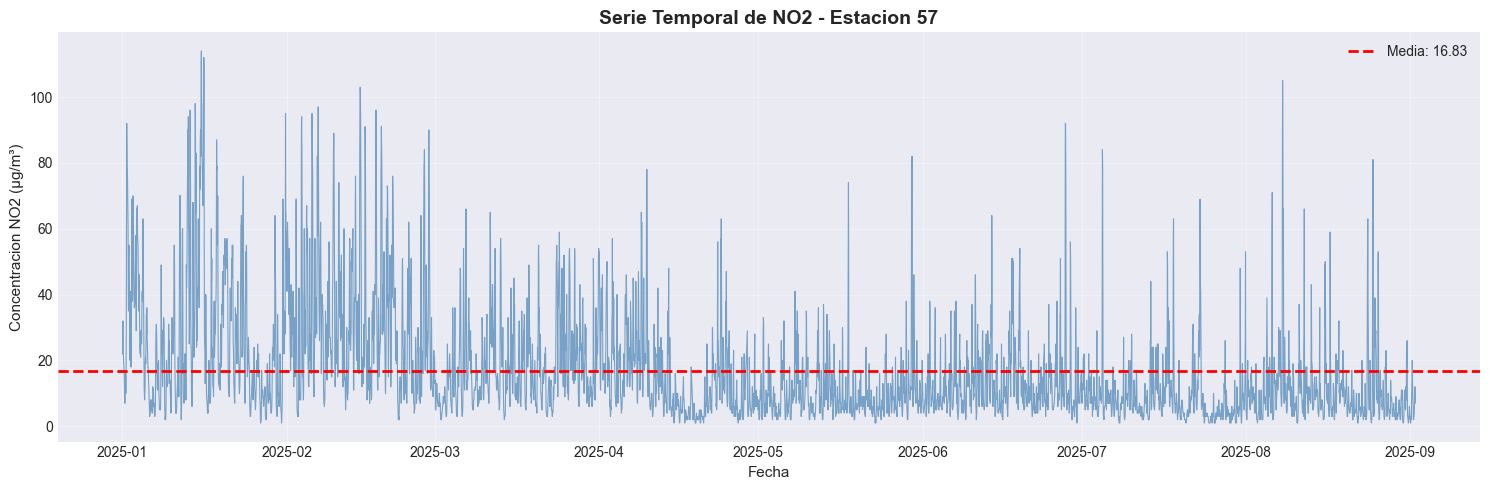

In [6]:
# Establece la columna datetime como indice de la serie temporal
df_estacion = df_estacion.sort_values('datetime')
df_estacion = df_estacion.set_index('datetime')

# Serie temporal completa
plt.figure(figsize=(15, 5))
plt.plot(df_estacion['valor'], linewidth=0.8, alpha=0.7, color='steelblue')
plt.axhline(df_estacion['valor'].mean(), color='red', linestyle='--', linewidth=2,
            label=f'Media: {df_estacion["valor"].mean():.2f}')
plt.title(f'Serie Temporal de NO2 - Estacion {estacion_principal}', fontsize=14, fontweight='bold')
plt.xlabel('Fecha', fontsize=11)
plt.ylabel('Concentracion NO2 (μg/m³)', fontsize=11)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### *Preparación de variables exógenas*

Para lograr una mejor precisión y capacidad predictiva en nuestros modelos, también incorporaremos información externa que influye en nuestra serie temporal.

Debido a que esta serie se corresponde con el valor del Dióxido de Nitrógeno a lo largo del tiempo, emplearemos principalmente variables metereológicas como fuentes de información. Obtenemos estas variables también del Portal de Datos del Ayuntamiento de Madrid, concretamente en el siguiente enlace:

https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=fa8357cec5efa610VgnVCM1000001d4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default

De la misma forma que sucedía para nuestra serie temporal, las mediciones aparecen con el mismo formato de fecha y hora, por lo que emplearemos de nuevo la función `wide_to_long` para lograr transformar el dataframe al formato adecuado. También filtraremos los datos de forma que las fechas coincidan con las de nuestra serie temporal.

Además, debemos tener en cuenta la estación metereológica más cercana a la estación de calidad de aire seleccionada. En este caso, será la estación 107.

In [7]:
# Obtenemos el dataset con los datos metereologicos
weather_df_raw = pd.read_csv('METEOROLOGIA_HORARIOS20250913.csv', sep=';')

# Filtramos unicamente los datos de la estacion 107, la mas cercana a la estacion de calidad del aire
weather_df_raw = weather_df_raw[weather_df_raw['ESTACION'] == 107]

weather_df_raw.head()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
6238,28,79,107,81,NaN,2025,1,1,0.8,V,...,0.0,V,0.0,V,0.1,V,0.0,V,0.1,V
6239,28,79,107,81,NaN,2025,1,2,0.1,V,...,0.0,N,0.0,N,0.0,N,0.0,N,0.0,N
6240,28,79,107,81,NaN,2025,1,3,0.0,V,...,0.0,N,0.0,N,0.0,N,0.0,N,0.0,N
6241,28,79,107,81,NaN,2025,1,4,0.2,V,...,0.0,N,0.0,N,0.0,N,0.0,N,0.0,N
6242,28,79,107,81,NaN,2025,1,5,0.2,V,...,0.0,N,0.0,N,0.0,N,0.0,N,0.0,N


In [8]:
# Ajustamos el formato del dataset metereologico
weather_df = wide_to_long(weather_df_raw)
display(weather_df.head())

# Obtenemos el rango temporal del dataset metereologico
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
weather_df = weather_df[weather_df['datetime'] <= pd.to_datetime('2025-09-01 23:00:00')]
print(f"Rango temporal: {weather_df['datetime'].min()} a {weather_df['datetime'].max()}")

,datetime,provincia,municipio,estacion,magnitud,punto_muestreo,valor,validacion
0,2025-01-01 00:00:00,28,79,107,81,NaN,0.8,V
1,2025-01-01 01:00:00,28,79,107,81,NaN,0.0,N
2,2025-01-01 02:00:00,28,79,107,81,NaN,0.1,V
3,2025-01-01 03:00:00,28,79,107,81,NaN,0.2,V
4,2025-01-01 04:00:00,28,79,107,81,NaN,0.3,V


Rango temporal: 2025-01-01 00:00:00 a 2025-09-01 23:00:00


Este dataframe funciona igual que el de nuestra serie temporal, por lo que también deberemos filtrar las mediciones válidas y eliminar los valores nulos.

In [9]:
# Filtrar solo datos válidos
weather_df = weather_df[weather_df['validacion'] == 'V'].copy()

# Convertir valores a numérico
weather_df['valor'] = pd.to_numeric(weather_df['valor'], errors='coerce')

# Eliminar valores nulos
weather_df = weather_df.dropna(subset=['valor'])

Una vez realizados los primeros pasos sobre el dataframe de variables exógenas, aún nos queda adaptarlo de forma que cada una de las magnitudes sean las columnas con su respectivo valor. Para ello, utilizaremos la función `wide_to_long_weather`, donde se mapea cada código a su correspondiente magnitud según la información obtenida del PDF asociado a este dataset y se construye el dataframe con el formato que queremos.

In [10]:
def wide_to_long_weather(df):
    """
    Reemplaza los códigos de magnitud por sus nombres.
    Pivota el DataFrame para que 'datetime' sea el índice y las magnitudes
    sean columnas con sus respectivos 'valor' en cada celda.
    """

    # Mapeo de códigos a nombres
    weather_map = {
        80: 'radiacion ultravioleta',
        81: 'velocidad viento',
        82: 'dir. viento',
        83: 'temperatura',
        86: 'humedad relativa',
        87: 'presion bariometrica',
        88: 'radiacion solar',
        89: 'precipitacion'
    }

    # Reemplazar los códigos numéricos por los nombres en la columna 'magnitud'
    df['magnitud_nombre'] = df['magnitud'].map(weather_map)

    # Asegurar que 'datetime' esté en formato correcto
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Transformación de 'long' a 'wide'
    final_df = df.pivot_table(
        index='datetime',             # Columna que se convierte en el índice (una fila por hora)
        columns='magnitud_nombre',    # Columna cuyos valores se convierten en nuevas columnas
        values='valor',               # Columna cuyos valores llenarán las nuevas columnas
        aggfunc='first'               # Usa 'first' ya que solo hay un valor por magnitud/hora
    ).reset_index() # Opcional: convierte 'datetime' de nuevo en una columna regular

    # Eliminar la columna magnitud_nombre
    new_columns = final_df.columns.get_level_values(-1).tolist()
    final_df.columns = new_columns
    final_df.columns.name = None

    return final_df

In [11]:
# Hacemos el ajuste final del dataset meterologico de forma que cada fila sea una hora y cada columna una variable metereologica
weather_df = wide_to_long_weather(weather_df)
weather_df.head()

,datetime,dir. viento,humedad relativa,precipitacion,presion bariometrica,radiacion solar,temperatura,velocidad viento
0,2025-01-01 00:00:00,32.0,75.0,0.0,948.0,1.0,1.5,0.8
1,2025-01-01 02:00:00,23.0,81.0,0.0,948.0,1.0,0.2,0.1
2,2025-01-01 03:00:00,17.0,78.0,0.0,948.0,2.0,0.9,0.2
3,2025-01-01 04:00:00,19.0,78.0,0.0,948.0,1.0,0.4,0.3
4,2025-01-01 05:00:00,16.0,81.0,0.0,948.0,1.0,-0.1,0.4


Además de las magnitudes metereológicas, también añadiremos a este dataframe como variables exógenas sintéticas tanto el seno como el coseno diario y semanal. Como veremos más adelante en el estudio de la serie temporal, será importante que nuestros modelos capturen las periodicidades de 24 horas y 1 semana de manera eficiente, permitiendo la identificación de dónde se encuentra la serie dentro de estos ciclos para hacer una predicción más precisa.

In [12]:
# Establece la columna datetime como indice de la serie temporal
weather_df = weather_df.sort_values('datetime')
weather_df = weather_df.set_index('datetime')

# Calculamos el seno y coseno diario
t_diario = np.arange(len(weather_df.index.hour))
periodo_diario = 24

weather_df['sin_diario'] = np.sin(2*np.pi*t_diario/periodo_diario)
weather_df['cos_diario'] = np.cos(2*np.pi*t_diario/periodo_diario)

# Calculamos el seno y coseno semanal
t_semanal = (weather_df.index.dayofweek * 24) + weather_df.index.hour
periodo_semanal = 24 * 7 # 168 horas

weather_df['sin_semanal'] = np.sin(2*np.pi*t_semanal/periodo_semanal)
weather_df['cos_semanal'] = np.cos(2*np.pi*t_semanal/periodo_semanal)

# Mostramos el ciclo completo diario
weather_df.head(26)

,dir. viento,humedad relativa,precipitacion,presion bariometrica,radiacion solar,temperatura,velocidad viento,sin_diario,cos_diario,sin_semanal,cos_semanal
datetime,,,,,,,,,,,
2025-01-01 00:00:00,32.0,75.0,0.0,948.0,1.0,1.5,0.8,0.000000e+00,1.000000e+00,0.974928,-0.222521
2025-01-01 02:00:00,23.0,81.0,0.0,948.0,1.0,0.2,0.1,2.588190e-01,9.659258e-01,0.955573,-0.294755
2025-01-01 03:00:00,17.0,78.0,0.0,948.0,2.0,0.9,0.2,5.000000e-01,8.660254e-01,0.943883,-0.330279
2025-01-01 04:00:00,19.0,78.0,0.0,948.0,1.0,0.4,0.3,7.071068e-01,7.071068e-01,0.930874,-0.365341
2025-01-01 05:00:00,16.0,81.0,0.0,948.0,1.0,-0.1,0.4,8.660254e-01,5.000000e-01,0.916562,-0.399892
2025-01-01 06:00:00,23.0,81.0,0.0,947.0,1.0,-0.4,0.5,9.659258e-01,2.588190e-01,0.900969,-0.433884
2025-01-01 07:00:00,19.0,78.0,0.0,947.0,1.0,0.1,0.5,1.000000e+00,6.123234e-17,0.884115,-0.467269
2025-01-01 08:00:00,21.0,77.0,0.0,948.0,4.0,0.3,0.5,9.659258e-01,-2.588190e-01,0.866025,-0.500000
2025-01-01 09:00:00,26.0,75.0,0.0,948.0,116.0,1.0,0.8,8.660254e-01,-5.000000e-01,0.846724,-0.532032


## **2. Análisis Exploratorio de Datos (EDA)**

Una vez cargada y preparada nuestra serie temporal, llevamos a cabo un EDA. Este análisis es fundamental para comprender las características del dataset de calidad del aire, identificar patrones temporales, detectar anomalías y guiar el desarrollo de los modelos predictivos, ayudando a la toma de decisiones informadas sobre el preprocesamiento necesario y las técnicas de modelado más apropiadas para la predicción de la calidad del aire.

En primer lugar, visualizamos la distribución de los valores del Dióxido de Nitrógeno.

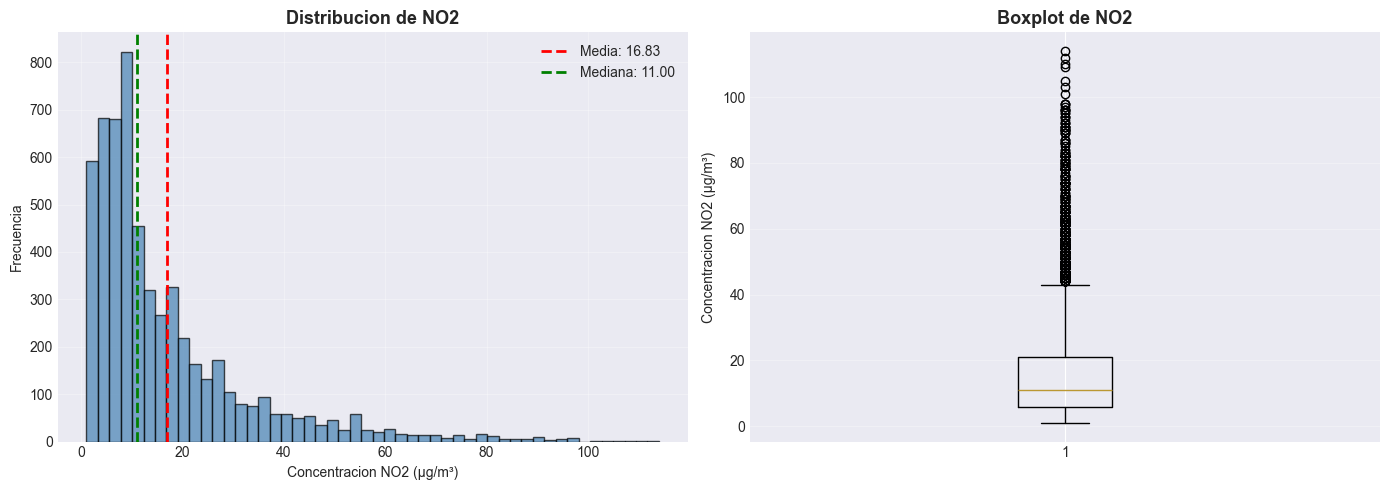

In [13]:
# Visualización simple de distribución
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(df_estacion['valor'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(df_estacion['valor'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {df_estacion["valor"].mean():.2f}')
axes[0].axvline(df_estacion['valor'].median(), color='green', linestyle='--', linewidth=2,
                label=f'Mediana: {df_estacion["valor"].median():.2f}')
axes[0].set_title('Distribucion de NO2', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Concentracion NO2 (μg/m³)')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
axes[1].boxplot(df_estacion['valor'], vert=True)
axes[1].set_title('Boxplot de NO2', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Concentracion NO2 (μg/m³)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Como se puede ver, la distribución de $\text{NO}_2$ es fuertemente simétrica positiva, como lo confirma la mediana, siendo significativamente inferior a la media, y el diagrama de cajas, mostrando un gran número de valores altos. Esto provocará que los modelos basados en el error cuadrático sean penalizados a la hora de tratar con estos outliers. Además, la dificultad para la normalidad podrá influir en las asunciones de los modelos autorregresivos.

A continuación, también estudiaremos la autocorrelación de la serie completa.

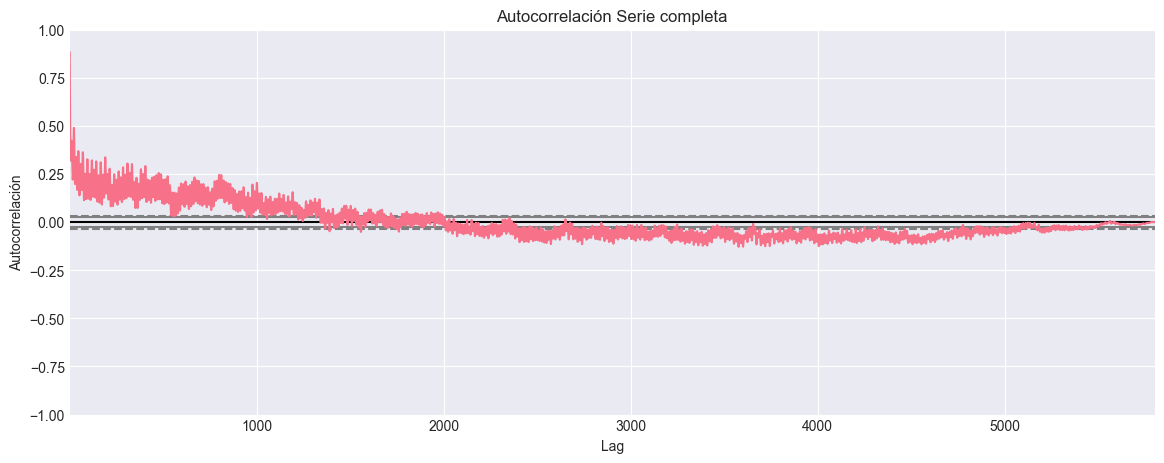

In [14]:
plt.figure(figsize=(14, 5))
autocorrelation_plot(df_estacion['valor'])
plt.title("Autocorrelación Serie completa")
plt.xlabel("Lag"); plt.ylabel("Autocorrelación"); plt.grid(True); plt.show()

El gráfico para la serie completa muestra que la autocorrelación se mantiene positiva y por encima del límite de confianza incluso después de mil lags. Sin embargo, se produce una caída súbita antes de los 200 lags, que luego se estabiliza disminuyendo más lentamente. Esta caída persistente es la característica distintiva de una serie temporal no estacionaria, implicando que el valor de $\text{NO}_2$ está influenciado también, aunque en menor medida, por observaciones que ocurrieron en los días o semanas anteriores.

Debido a estos resultados, vamos a estudiar en más detalle como se comporta la autocorrelación del valor actual en relación con el valor de hace 1 hora (lag 1), hace 1 día (lag 24), hace 2 días (lag 48), hace 3 días (lag 72) y hace 1 semana (lag 168.)

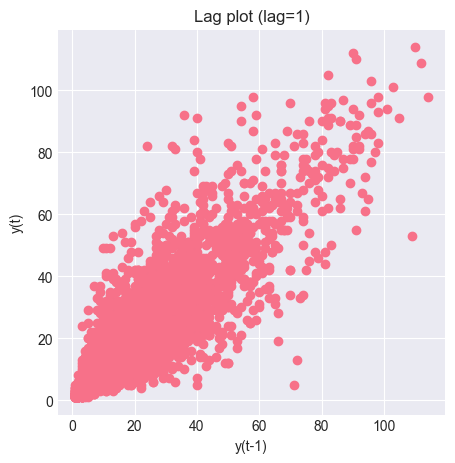

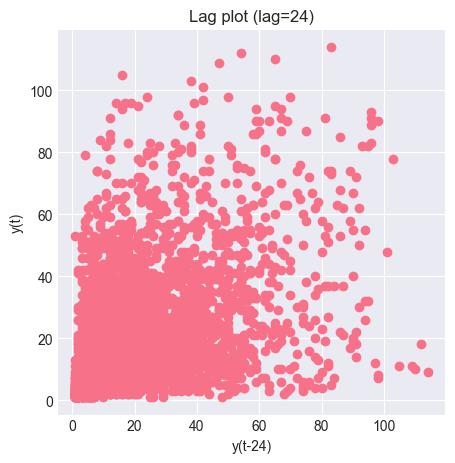

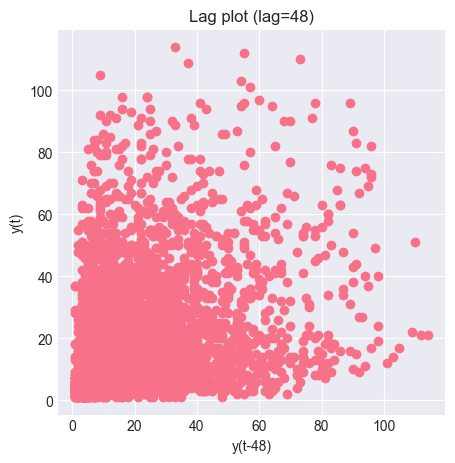

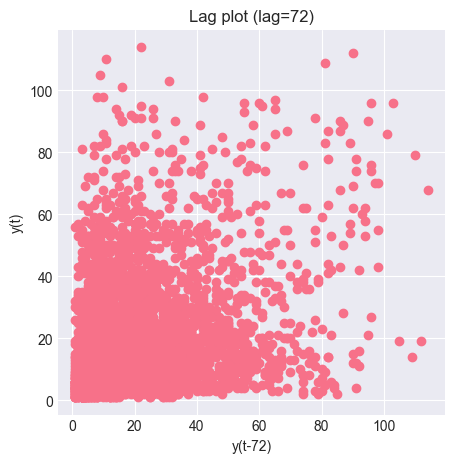

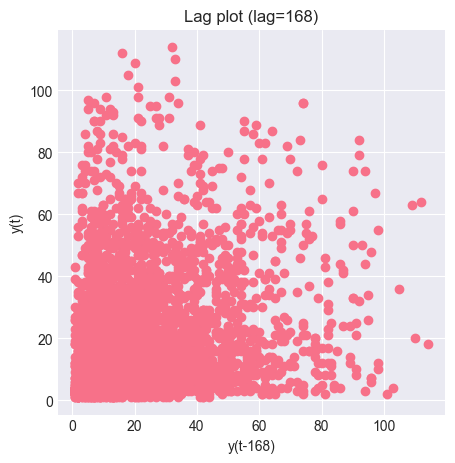

In [15]:
for lag in [1, 24, 48, 72, 168]:
    plt.figure(figsize=(5,5))
    lag_plot(df_estacion['valor'], lag=lag)
    plt.title(f"Lag plot (lag={lag})")
    plt.xlabel(f"y(t-{lag})"); plt.ylabel("y(t)"); plt.grid(True); plt.show()

El lag plot para el lag 1 revela una correlación lineal positiva excepcional al agruparse los puntos alrededor de la diagonal, lo que implica que el valor actual de $\text{NO}_2$ es casi siempre una continuación directa de la hora anterior. 

Por el contrario, los gráficos para los lags mayores muestran una pérdida progresiva de la estructura lineal, transformándose en nubes de puntos mucho más dispersas. Este patrón indica que la influencia directa de los valores de días anteriores se debilita. Sin embargo, no existe gran diferencia entre ellos, lo que puede sugerir una estacionalidad diaria, o incluso semanal, de la serie.

Para comprobar esta hipótesis, visualizamos la Función de Autocorrelación para 1 semana.

<Figure size 1000x500 with 0 Axes>

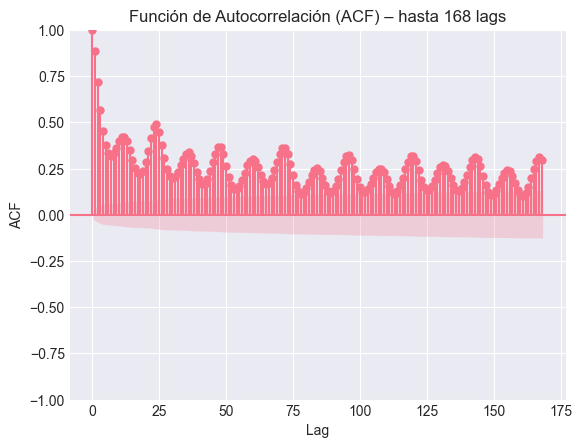

In [16]:
LAGS_ACF = 168
plt.figure(figsize=(10,5))
plot_acf(df_estacion['valor'], lags=LAGS_ACF, alpha=0.05)
plt.title(f"Función de Autocorrelación (ACF) – hasta {LAGS_ACF} lags")
plt.xlabel("Lag"); plt.ylabel("ACF"); plt.grid(True); plt.show()

Esta nueva gráfica más comprimida confirma la no estacionariedad de la serie, comprobándose de nuevo la lenta y persistente caída de la autocorrelación a lo largo de los 168 lags y haciendo obligatoria una diferenciación estacional (d=1).

Más allá de la dependencia a corto plazo, la serie presenta una doble estacionalidad. En primer lugar, la diaria se confirma por la repetición de picos significativos en los lags 24, 48 y 72, indicando que el nivel de $\text{NO}_2$ se relaciona fuertemente con el nivel de la misma hora en días anteriores. Adicionalmente, se produce un notable pico en el lag 168, confirmando una estacionalidad semanal. Estos patrones indican que un modelo como SARIMAX debería incorporar términos estacionales para ambos periodos (s=24 y s=168) para capturar completamente la variabilidad de la serie. Sin embargo, debido a la alta capacidad de cómputo necesaria para evaluar el modelo para s=168 y que el pico en el lag 24 es más significativo, únicamente se probará con s=24.

Como último paso de este EDA, analizaremos la Función de Autocorrelación Parcial con el objetivo de identificar el orden p del componente Autorregresivo no estacional y el orden P del componente SAR estacional para el modelo SARIMAX.

<Figure size 1000x500 with 0 Axes>

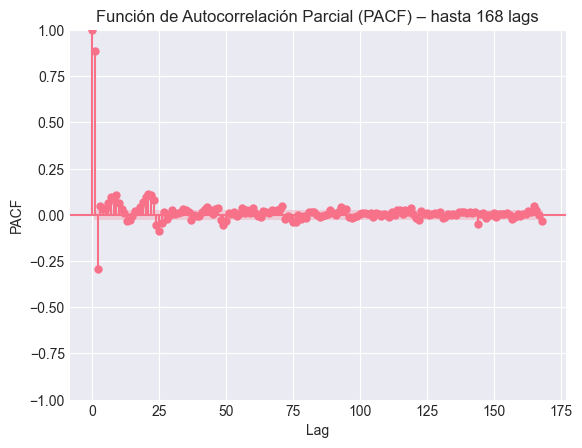

In [17]:
LAGS_PACF = 168
plt.figure(figsize=(10,5))
plot_pacf(df_estacion['valor'], lags=LAGS_PACF, alpha=0.05, method="ywm")
plt.title(f"Función de Autocorrelación Parcial (PACF) – hasta {LAGS_PACF} lags")
plt.xlabel("Lag"); plt.ylabel("PACF"); plt.grid(True); plt.show()

El análisis de esta función nos muestra una rápida caída a cero en los primeros lags, con un pico altamente significativo en el lag 1, un segundo pico significativo y negativo en el lag 2 y un corte abrupto de la correlación parcial inmediatamente después. Esto establece el componente no estacional a probar como AR(2) (p=2), ya que la influencia directa del valor actual proviene de las dos horas anteriores. En consecuencia, el orden de la Media Móvil (q) se establece como q=0, asumiendo que el componente AR(2) es suficiente para explicar toda la correlación a corto plazo.

Destacamos también la ausencia de picos significativos en los lags 24 y 168. Esta falta de correlación con la estacionalidad demostrada por la ACF implica que la dependencia cíclica no es de tipo puramente autorregresivo, sino que se explica por el componente de la media móvil estacional. Por ello, se fijarán los términos P=0 y Q=1. De esta manera, se priorizará la prueba con la diferenciación estacional (D=0 y D=1) para determinar si la media de la estacionalidad es estacionaria o no.

## **3. Evaluación de Modelos**

Teniendo en cuenta los descubrimientos acerca de nuestra serie encontrados en el EDA, en este apartado vamos a evaluar diferentes modelos, tanto de aprendizaje automático clásico como estadísticos, para encontrar aquel que se ajusta mejor a nuestra serie.

Para ello, preparamos los conjuntos de train, validación y test tanto para los valores de la serie a predecir como para las variables exógenas.

In [18]:
# Inferir frecuencia si existe
HORIZON = 24
y = df_estacion['valor'].astype(float)
y = y.astype(float).sort_index()
freq = pd.infer_freq(y.index)

# Heuristica: si no infiere frecuencia, asumir horaria ya que los datos deberian medirse cada hora
if freq is None:
    freq = 'H'

if freq is not None:
    y = y.asfreq(freq)

# Imputación de faltantes (interpolación temporal)
if y.isna().any():
    y = y.interpolate(method='time', limit_direction='both')

# Division simple
y_test = y[y.index > pd.to_datetime('2025-08-31 23:00:00')]
y = y[y.index <= pd.to_datetime('2025-08-31 23:00:00')]
y_train, y_valid = y.iloc[:-HORIZON], y.iloc[-HORIZON:]

if freq is not None:
    y_train.index = pd.DatetimeIndex(y_train.index, freq=freq)
    y_valid.index = pd.DatetimeIndex(y_valid.index, freq=freq)

print(f'Freq: {freq}')
print(f'Rango Serie Train: {y_train.index[0].date()} → {y_train.index[-1].date()} (n={len(y_train)})')
print(f'Rango Serie Valid: {y_valid.index[0].date()} → {y_valid.index[-1].date()} (n={len(y_valid)})')
print(f'Rango Serie Test: {y_test.index[0].date()} → {y_test.index[-1].date()} (n={len(y_test)})')

Freq: H
Rango Serie Train: 2025-01-01 → 2025-08-30 (n=5808)
Rango Serie Valid: 2025-08-31 → 2025-08-31 (n=24)
Rango Serie Test: 2025-09-01 → 2025-09-01 (n=24)


In [19]:
# Inferir frecuencia si existe
X = weather_df[weather_df.index <= pd.to_datetime('2025-08-31 23:00:00')]
X_pred = weather_df.reindex(
    pd.date_range(start=pd.to_datetime('2025-09-01 00:00:00'), end=pd.to_datetime('2025-09-01 23:00:00'), freq='H')
)
freq = pd.infer_freq(X.index)

# Heuristica: si no infiere frecuencia, asumir horaria ya que los datos metereologicos deberian medirse cada hora
if freq is None:
    freq = 'H'

if freq is not None:
    X = X.asfreq(freq)
    X_pred = X_pred.asfreq(freq)

# Imputación de faltantes (interpolación temporal)
if X.isna().any().any():
    X = X.interpolate(method='time', limit_direction='both')
    
if X_pred.isna().any().any():
    X_pred = X_pred.interpolate(method='time', limit_direction='forward')

print(f'Freq: {freq}')
print(f'Rango Variables Exogenas Train: {X.index[0].date()} → {X.index[-1].date()} (n={len(X)})')
print(f'Rango Variables Exogenas Pred: {X_pred.index[0].date()} → {X_pred.index[-1].date()} (n={len(X_pred)})')

Freq: H
Rango Variables Exogenas Train: 2025-01-01 → 2025-08-31 (n=5832)
Rango Variables Exogenas Pred: 2025-09-01 → 2025-09-01 (n=24)


Como paso previo a la evaluación de modelos más complejos, vamos a probar los modelos AR y ARIMA, con el objetivo de validar la necesidad del modelo SARIMAX.

Para ello, comenzamos evaluando cual será el valor de p más óptimo para nuestreo modelo AR.

In [20]:
resultados = []
modelos = {}

for p in range(1, 6):  # p=1..5
    try:
        model = AutoReg(y_train, lags=p, old_names=False).fit()
        modelos[p] = model
        resultados.append({
            "p": p,
            "AIC (train)": model.aic
        })
    except Exception as e:
        print(f"p={p} falló: {e}")

tabla = pd.DataFrame(resultados).set_index("p").sort_values("AIC (train)")
print("AIC en entrenamiento:")
display(tabla)

AIC en entrenamiento:


,AIC (train)
p,
5,39546.644882
4,39557.457697
3,39566.834068
2,39586.219202
1,40144.568714


El análisis de los modelos AR según el AIC en el conjunto de entrenamiento muestra una clara tendencia decreciente a medida que se incrementa el orden p. Esta disminución continua del AIC es un comportamiento típico en series intrínsecamente no estacionarias y estacionales. La razón de este patrón es que el modelo AR simple, al carecer de diferenciación y términos estacionales, intenta capturar la tendencia de largo plazo y la estacionalidad diaria utilizando términos de orden superior.

Por lo tanto, como veremos en la predicción de AR(5), su bajo AIC es una estimación sesgada que confirma la necesidad de SARIMAX.

Mejor p por AIC: 5
MAE (últimas 24 obs): 9.622
RMSE (últimas 24 obs): 10.715


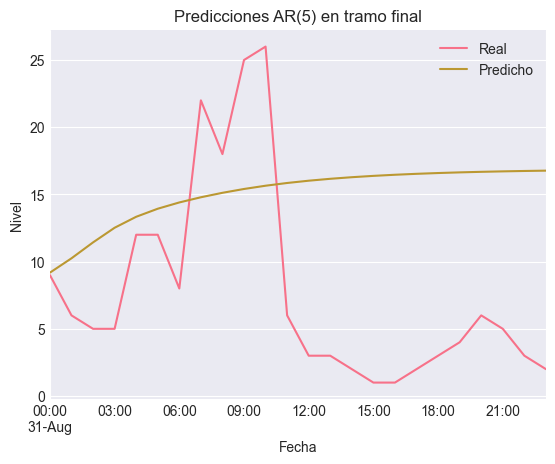

In [21]:
# Selecciona el mejor p por AIC (calculado en TRAIN)
mejor_p = int(tabla["AIC (train)"].idxmin())
print(f"Mejor p por AIC: {mejor_p}")

# Entrena SOLO con el tramo de entrenamiento
res = AutoReg(y_train, lags=mejor_p, old_names=False, missing="drop").fit()

# Pronóstico OOS recursivo 
history = list(y_train.iloc[-mejor_p:][::-1]) 

# Coeficientes AR y constante
params = res.params
const = float(params.get("const", 0.0))
phis = []
for i in range(1, mejor_p + 1):
    for key in (f"L{ i }.y", f"y.L{ i }", f"L{i}"):
        if key in params.index:
            phis.append(float(params[key]))
            break
    else:
        phis.append(float(params[-mejor_p + (i-1)]))

phis = np.array(phis) 

# Generamos predicciones recursivas
pred_vals = []
for _ in range(HORIZON):
    y_hat = const + float(np.dot(phis, history[:mejor_p]))
    pred_vals.append(y_hat)
    history = [y_hat] + history[:mejor_p-1]

# Serie de predicciones con el índice de validación
pred = pd.Series(pred_vals, index=y_valid.index)

# Métricas
def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

MAE = mae(y_valid, pred)
RMSE = rmse(y_valid, pred)
print(f"MAE (últimas {len(y_valid)} obs): {MAE:.3f}")
print(f"RMSE (últimas {len(y_valid)} obs): {RMSE:.3f}")

# Visualización
plt.figure()
y_valid.plot(label="Real", title=f"Predicciones AR({mejor_p}) en tramo final")
pred.plot(label="Predicho")
plt.xlabel("Fecha"); plt.ylabel("Nivel"); plt.legend()
plt.show()


Aquí vemos como el gráfico de predicción para AR(5) confirma el fracaso que esperábamos, al no poder capturar la estacionalidad del valor real y obtener errores consistentemente altos. Este resultado valida nuestro análisis previo, demostrando que la dependencia a corto plazo, aunque significativa, no es suficiente por sí sola. 

Ahora, evaluamos ARIMA utilizando el orden previamente identificado para verificar si la direnciación será suficiente para capturar la tendencia a largo plazo.


[ARIMA(2, 1, 0)] MAE=5.967  RMSE=7.386


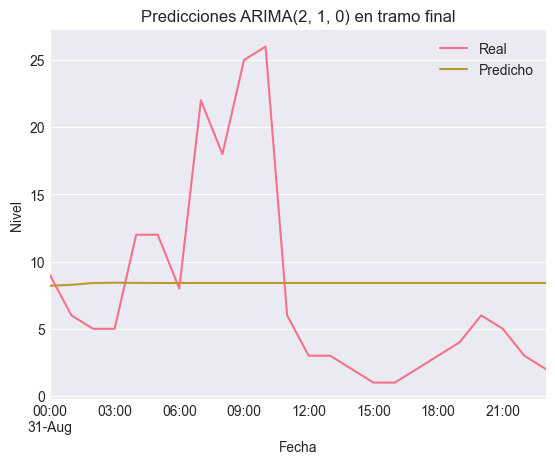

In [22]:
# Ajuste ARIMA sobre la serie original
order = (2,1,0)
modelo_arima = ARIMA(y_train, order=order)
res_arima = modelo_arima.fit()

# 2) Pronóstico Out-of-Sample (OOS) sobre y_valid
forecast_obj = res_arima.get_forecast(steps=len(y_valid))
pred_arima = forecast_obj.predicted_mean
# Alineación del índice
pred_arima.index = y_valid.index

# 3) Métricas
MAE_arima = mae(y_valid, pred_arima)
RMSE_arima = rmse(y_valid, pred_arima)
print(f"\n[ARIMA{order}] MAE={MAE_arima:.3f}  RMSE={RMSE_arima:.3f}")

# 4) Visualización
plt.figure()
y_valid.plot(label="Real", title=f"Predicciones ARIMA{order} en tramo final")
pred_arima.plot(label="Predicho")
plt.xlabel("Fecha"); plt.ylabel("Nivel"); plt.legend()
plt.show()


El pronóstico de ARIMA(2, 1, 0) muestra otro fracaso similar al de AR(5), a pesar de incluir la diferenciación. La línea predicha se vuelve rápidamente horizontal, obteniendo de nuevo valores altos (aunque mejores) para las métricas de error. De esta manera, se demuestra que la dependencia a corto plazo y la estabilización de la serie siguen siendo insuficientes. Estos resultados validan el diagnóstico de que la estacionalidad es el factor dominante que falta en el modelo, confirmando de nuevo que el modelo a evaluar debe ser SARIMAX.

Antes de pasar a la evaluación de los modelos, definimos el objeto para realizar la validación cruzada en la serie temporal y 3 funciones (adaptadas del código proporcionado por el profesor) que nos ayudarán a hacer más robusta nuestra validación de modelos.

In [23]:
# Definicion del cv
cv = TimeSeriesFold(steps=HORIZON, initial_train_size=len(y)-HORIZON, fixed_train_size=True)

# -----------------------------------------------------------------------------
# === Helpers robustos para grid-search y backtesting ===
# -----------------------------------------------------------------------------

def tune_model(y, regressor, param_grid, lags_grid, cv, exog=None, metric='mean_absolute_error', ignore_freq=None):
    """
    Ejecuta grid_search_forecaster() o grid_search_sarimax() y devuelve SIEMPRE:
      - results_df: DataFrame con combinaciones evaluadas
      - f_best: Forecaster ajustado con la mejor configuración
    """
    kwargs = dict(
        y=y, exog=exog, cv=cv, param_grid=param_grid,
        metric=metric, return_best=True, verbose=False
    )

    if ignore_freq:
        kwargs['ignore_freq'] = True

    if isinstance(regressor, Sarimax):
        # Forecaster para el Grid Sarimax
        f = ForecasterSarimax(regressor=regressor)
        kwargs['forecaster'] = f
        out = grid_search_sarimax(**kwargs) 

        if isinstance(out, pd.DataFrame):
            results_df = out
            f_best = f 
        else:
            results_df, f_best = out
        
    else:
        # Para modelos de ML
        f = ForecasterRecursive(regressor=regressor, lags=lags_grid[0] if len(lags_grid) else 12)
        kwargs['forecaster'] = f
        kwargs['lags_grid'] = lags_grid
        out = grid_search_forecaster(**kwargs)

        if isinstance(out, dict) and 'results' in out and 'forecaster' in out:
            results_df, f_best = out['results'], out['forecaster']
        else:
            results_df, f_best = out, f

    return results_df, f_best


def backtest_best(f_best, y, cv, exog=None, metric='mean_absolute_error', ignore_freq=None):
    """
    Devuelve:
      - metrics_out: métricas por split (tipo varía por versión)
      - preds_out: DF de predicciones o None
    Soporta backtesting_forecaster y backtesting_sarimax.
    """
    kwargs = dict(forecaster=f_best, y=y, exog=exog, cv=cv, metric=metric, verbose=False)
    if ignore_freq:
        kwargs['ignore_freq'] = True

    # Si es ForecasterSarimax, usamos su función de backtesting.
    if isinstance(f_best, ForecasterSarimax):
        metrics_out, preds_out = backtesting_sarimax(**kwargs)
        return metrics_out, preds_out
        
    else:
        # Para modelos de ML, usamos backtesting_forecaster.
        try:
            metrics_out, preds_out = backtesting_forecaster(return_predict=True, **kwargs)
        except TypeError:
            out = backtesting_forecaster(**kwargs)
            if isinstance(out, tuple) and len(out) == 2:
                metrics_out, preds_out = out
            else:
                metrics_out, preds_out = out, None

        return metrics_out, preds_out


def extract_mae(metrics_out, metric_name='mean_absolute_error'):
    """Extrae un MAE medio de la salida de métricas, sea float/Series/DataFrame."""
    import numpy as _np
    import pandas as _pd
    if isinstance(metrics_out, (float, int, _np.floating, _np.integer)):
        return float(metrics_out)
    if isinstance(metrics_out, _pd.Series):
        return float(_pd.to_numeric(metrics_out, errors='coerce').mean())
    if isinstance(metrics_out, _pd.DataFrame):
        df = metrics_out.copy()
        if {'metric','value'}.issubset(df.columns):
            mask = (df['metric'] == metric_name)
            if mask.any():
                return float(_pd.to_numeric(df.loc[mask, 'value'], errors='coerce').mean())
            return float(_pd.to_numeric(df['value'], errors='coerce').mean())
        if metric_name in df.columns:
            return float(_pd.to_numeric(df[metric_name], errors='coerce').mean())
        if 'value' in df.columns:
            return float(_pd.to_numeric(df['value'], errors='coerce').mean())
        num = df.select_dtypes(include=_np.number)
        if not num.empty:
            return float(num.iloc[:, 0].mean())
    raise ValueError('Formato de métricas no reconocido para extraer MAE.')

# Intentar graficar predicciones (si existen) del último tramo
def plot_cv_preds(preds, label):
    # Función auxiliar para graficar la columna de predicciones si existe
    if preds is None or not isinstance(preds, pd.DataFrame):
        return False
    # Intentamos encontrar la columna de predicción
    for col in ['pred', 'prediction', 'y_pred', 'forecast', 'yhat']:
        if col in preds.columns:
            # Graficar la columna y añadir etiqueta
            preds[col].plot(label=label)
            return True
    return False

Probaremos múltiples modelos de diferentes tipos para elegir el que mejor capture la dinámica de nuestra serie. Entre estos tipos tenemos los siguientes:

- Modelos Lineales (`Ridge` y `ElasticNet`): utilizarán además un `MinMaxScaler`, asegurando un escalado para las variables exógenas antes de la regresión, crucial para la regularización.

- Modelos Basados en Árboles (`Decision Tree`, `Random Forest` y `Gradient Boosting`): robustos para capturar relaciones no lineales en los datos.

- Modelo de Series Temporales (`SARIMAX`): haciendo uso de las conclusiones obtenidas en el análisis de la serie temporal.

Primeramente, evaluaremos los modelos sin emplear las variables exógenas, probando únicamente diferentes lags.

lags grid: 100%|██████████| 5/5 [00:00<00:00, 29.42it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
  Parameters: {'regressor__alpha': 10.0}
  Backtesting metric: 5.1752871520913715


lags grid: 100%|██████████| 5/5 [00:00<00:00, 24.01it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.8}
  Backtesting metric: 5.995060571808144


lags grid: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'max_depth': 12, 'min_samples_split': 2}
  Backtesting metric: 3.932164043410515


lags grid: 100%|██████████| 5/5 [00:33<00:00,  6.66s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': 10, 'n_estimators': 300}
  Backtesting metric: 4.529520113798503


lags grid: 100%|██████████| 5/5 [04:29<00:00, 53.87s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 3.6993499643741887
Number of models compared: 2.


params grid: 100%|██████████| 2/2 [00:05<00:00,  2.69s/it]


`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (2, 1, 0), 'seasonal_order': (0, 0, 1, 24)}
  Backtesting metric: 5.97247430619623



100%|██████████| 1/1 [00:00<00:00, 412.01it/s]

Comparación de MAE (promedio CV):


,modelo,mae
4,GradientBoosting,3.699350
2,DecisionTree,3.932164
3,RandomForest,4.529520
0,Ridge,5.175287
5,Sarimax,5.972474
1,ElasticNet,5.995061


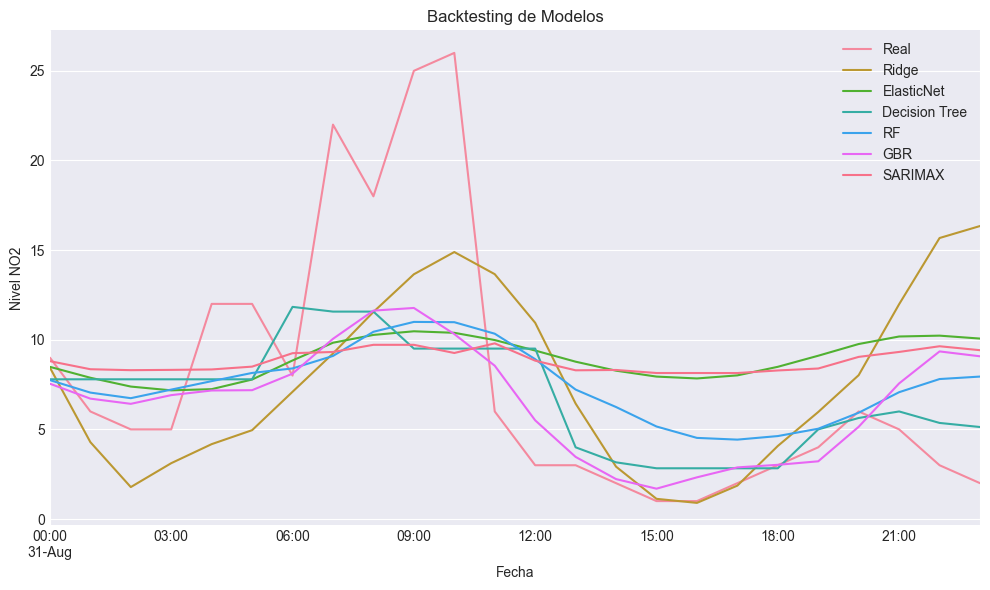

In [24]:
# === 1. Inicialización de Modelos ===
ridge = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', Ridge(random_state=0))
])
elasticnet = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', ElasticNet(random_state=0, max_iter=10000))
])
tree  = DecisionTreeRegressor(random_state=0)
rf    = RandomForestRegressor(random_state=0, n_estimators=300, n_jobs=-1)
gbr   = GradientBoostingRegressor(random_state=0, n_estimators=300)
sarimax = Sarimax()

# === 2. Rejilla de Lags ===
lags_grid = [1, 24, 48, 72, 168]

# === 3. Rejillas de Hiperparámetros ===

# Ridge
param_grid_ridge = {
    'regressor__alpha': [0.01, 0.1, 1.0, 5.0, 10.0]
}

# ElasticNet
param_grid_elasticnet = {
    'regressor__alpha': [0.1, 1.0],
    'regressor__l1_ratio': [0.2, 0.5, 0.8]
}

# Decision Tree
param_grid_tree  = {
    'max_depth': [3, 6, 12, None],
    'min_samples_split': [2, 5]
}

# Random Forest
param_grid_rf    = {
    'n_estimators': [100, 300],
    'max_depth': [5, 10]
}

# Gradient Boosting
param_grid_gbr   = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2]
}

# Sarimax
# Órdenes No Estacionales (p, d, q)
p = 2
d = 1
q = 0

# Órdenes Estacionales (P, D, Q)
P = 0
D = [0, 1]
Q = 1
s_freq = 24

param_grid_sarimax = {
    'order': [(p, d, q)],
    'seasonal_order': [(P, i, Q, s_freq) for i in D]
}

# === 4. Ejecución del Tuning ===
ridge_results,      f_ridge_best      = tune_model(y, ridge,      param_grid_ridge,      lags_grid, cv)

elasticnet_results, f_elasticnet_best = tune_model(y, elasticnet, param_grid_elasticnet, lags_grid, cv)

tree_results,       f_tree_best       = tune_model(y, tree,       param_grid_tree,       lags_grid, cv)

rf_results,         f_rf_best         = tune_model(y, rf,         param_grid_rf,         lags_grid, cv)

gbr_results,        f_gbr_best        = tune_model(y, gbr,        param_grid_gbr,        lags_grid, cv)

sarimax_results,    f_sarimax_best    = tune_model(y, sarimax,    param_grid_sarimax,    lags_grid, cv)

# === Backtesting con los mejores modelos ==
m_ridge,      p_ridge      = backtest_best(f_ridge_best, y, cv)
m_elasticnet, p_elasticnet = backtest_best(f_elasticnet_best, y, cv)
m_tree,       p_tree       = backtest_best(f_tree_best,  y, cv)
m_rf,         p_rf         = backtest_best(f_rf_best,    y, cv)
m_gbr,        p_gbr        = backtest_best(f_gbr_best,   y, cv)
m_sarimax,    p_sarimax    = backtest_best(f_sarimax_best, y, cv)

# Comparación de MAE
compare = pd.DataFrame({
    'modelo': ['Ridge', 'ElasticNet', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'Sarimax'],
    'mae': [
        extract_mae(m_ridge,      'mean_absolute_error'),
        extract_mae(m_elasticnet, 'mean_absolute_error'),
        extract_mae(m_tree,       'mean_absolute_error'),
        extract_mae(m_rf,         'mean_absolute_error'),
        extract_mae(m_gbr,        'mean_absolute_error'),
        extract_mae(m_sarimax,    'mean_absolute_error'),
    ],
}).sort_values('mae')

print('Comparación de MAE (promedio CV):')
display(compare)

plt.figure(figsize=(10, 6))
y_valid.plot(label='Real', alpha=0.8, title='Backtesting de Modelos')
ok = False
ok |= plot_cv_preds(p_ridge,      'Ridge')
ok |= plot_cv_preds(p_elasticnet, 'ElasticNet')
ok |= plot_cv_preds(p_tree,       'Decision Tree')
ok |= plot_cv_preds(p_rf,         'RF')
ok |= plot_cv_preds(p_gbr,        'GBR')
ok |= plot_cv_preds(p_sarimax,    'SARIMAX')

plt.xlabel('Fecha'); plt.ylabel('Nivel NO2')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

Los resultados del backtesting de los modelos demuestran que los modelos basados en árboles son los que mejor funcionan por el momento, superando incluso al enfoque clásico de series temporales. Vemos que estos modelos son efectivos al capturar relaciones no lineales entre los lags pasados y el valor actual, lo que les permite replicar mejor los picos y valles de la serie.

Dado que buscamos optimizar al máximo nuestro predictor, ahora incluiremos variables exógenas para una nueva evaluación de estos modelos.

lags grid: 100%|██████████| 5/5 [00:00<00:00, 34.91it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'regressor__alpha': 10.0}
  Backtesting metric: 5.8643289010319934


lags grid: 100%|██████████| 5/5 [00:00<00:00, 29.85it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.5}
  Backtesting metric: 3.61064878276042


lags grid: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': None, 'min_samples_split': 2}
  Backtesting metric: 4.166666666666667


lags grid: 100%|██████████| 5/5 [00:36<00:00,  7.31s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'max_depth': 10, 'n_estimators': 300}
  Backtesting metric: 4.806331529750491


lags grid: 100%|██████████| 5/5 [05:27<00:00, 65.42s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
  Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
  Backtesting metric: 2.633865672680074
Number of models compared: 2.


params grid: 100%|██████████| 2/2 [01:07<00:00, 33.62s/it]


`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (2, 1, 0), 'seasonal_order': (0, 0, 1, 24)}
  Backtesting metric: 4.340337963285472



100%|██████████| 1/1 [00:00<00:00, 416.31it/s]

Comparación de MAE (promedio CV):


,modelo,mae
4,GradientBoosting,3.679702
1,ElasticNet,3.949010
5,Sarimax,4.340338
3,RandomForest,4.807984
2,DecisionTree,5.868380
0,Ridge,6.886213


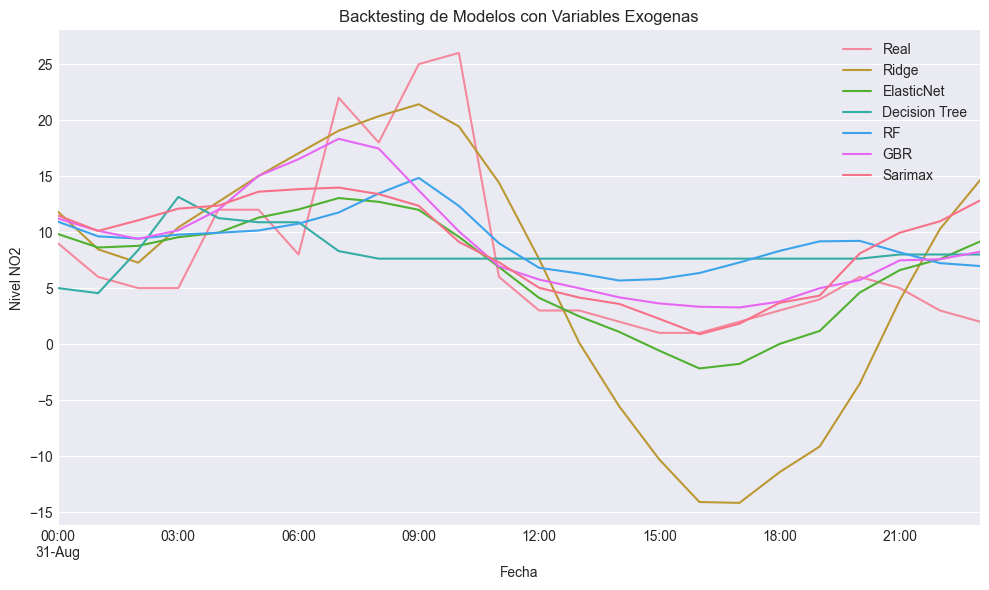

In [25]:
# Ejecucion del tuning con variables exogenas
ridge_results_exog,      f_ridge_best_exog      = tune_model(y, ridge,      param_grid_ridge,      lags_grid, cv, X)

elasticnet_results_exog, f_elasticnet_best_exog = tune_model(y, elasticnet, param_grid_elasticnet, lags_grid, cv, X)

tree_results_exog,       f_tree_best_exog       = tune_model(y, tree,       param_grid_tree,       lags_grid, cv, X)

rf_results_exog,         f_rf_best_exog         = tune_model(y, rf,         param_grid_rf,         lags_grid, cv, X)

gbr_results_exog,        f_gbr_best_exog        = tune_model(y, gbr,        param_grid_gbr,        lags_grid, cv, X)

sarimax_results_exog,    f_sarimax_best_exog    = tune_model(y, sarimax,    param_grid_sarimax,    lags_grid, cv, X)

# Bactesting con variables exogenas
m_ridge_exog,      p_ridge_exog      = backtest_best(f_ridge_best, y, cv, X)
m_elasticnet_exog, p_elasticnet_exog = backtest_best(f_elasticnet_best, y, cv, X)
m_tree_exog,       p_tree_exog       = backtest_best(f_tree_best, y, cv, X)
m_rf_exog,         p_rf_exog         = backtest_best(f_rf_best, y, cv, X)
m_gbr_exog,        p_gbr_exog        = backtest_best(f_gbr_best, y, cv, X)
m_sarimax_exog,    p_sarimax_exog    = backtest_best(f_sarimax_best, y, cv, X)

# Comparación de MAE
compare_exog = pd.DataFrame({
    'modelo': ['Ridge', 'ElasticNet', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'Sarimax'],
    'mae': [
        extract_mae(m_ridge_exog,      'mean_absolute_error'),
        extract_mae(m_elasticnet_exog, 'mean_absolute_error'),
        extract_mae(m_tree_exog,       'mean_absolute_error'),
        extract_mae(m_rf_exog,         'mean_absolute_error'),
        extract_mae(m_gbr_exog,        'mean_absolute_error'),
        extract_mae(m_sarimax_exog,    'mean_absolute_error')
    ],
}).sort_values('mae')

print('Comparación de MAE (promedio CV):')
display(compare_exog)

# Graficos comparativos
plt.figure(figsize=(10, 6))
y_valid.plot(label='Real', alpha=0.8, title='Backtesting de Modelos con Variables Exogenas')
ok = False
ok |= plot_cv_preds(p_ridge_exog,      'Ridge')
ok |= plot_cv_preds(p_elasticnet_exog, 'ElasticNet')
ok |= plot_cv_preds(p_tree_exog,       'Decision Tree')
ok |= plot_cv_preds(p_rf_exog,         'RF')
ok |= plot_cv_preds(p_gbr_exog,        'GBR')
ok |= plot_cv_preds(p_sarimax_exog,    'Sarimax')

# Título ajustado para reflejar el éxito de la predicción
plt.xlabel('Fecha'); plt.ylabel('Nivel NO2')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

Vemos que, como era de esperar, la inclusión de variables exógenas muestran una mejora sustancial en el rendimiento de los modelos, especialmente para SARIMAX. Sin embargo, Gradient Boosting mantiene su posición como el mejor de todos, prediciendo con precisión la tendencia general del ciclo diario. Por lo tanto, será este modelo el que usemos para llevar a cabo la predicción final.

Para observar mejor este cambio y la importancia de las variables exógenas, ahora mostramos una comparativa para Gradient Boosting con y sin el uso de variables exógenas.

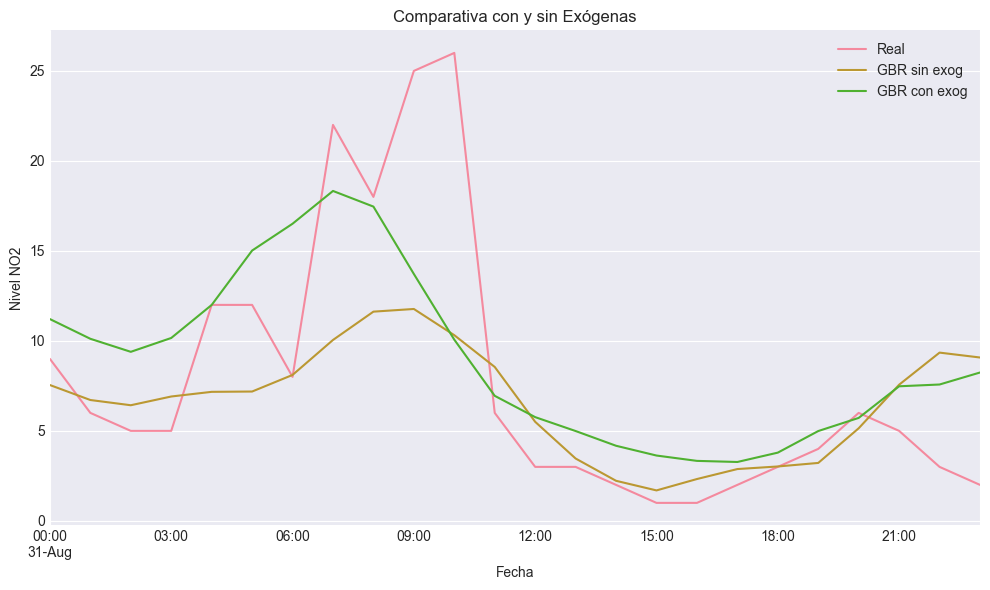

In [26]:
# Comparativa con exog y sin exog
plt.figure(figsize=(10, 6))
y_valid.plot(label='Real', alpha=0.8, title='Comparativa con y sin Exógenas')
ok = False
ok |= plot_cv_preds(p_gbr, 'GBR sin exog')
ok |= plot_cv_preds(p_gbr_exog, 'GBR con exog')

# Título ajustado para reflejar el éxito de la predicción
plt.xlabel('Fecha'); plt.ylabel('Nivel NO2')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

Esta gráfica demuestra la importancia crítica de las variables exógenas y cómo mejora nuestro modelo. Sin ellas, la predicción tiende a ser más suave, resultando en un MAE mayor. Al incluirlas, el modelo mejora marginalmente el error, pero logra una mejor aproximación cualitativa a los valores reales. Esto confirma que, si bien los lags son la base, la información de variables externas resulta esencial para ajustar la magnitud y el ciclo del valor de $\text{NO}_2$.

## **4. Predicción final**

Como último paso del notebook, realizamos la predicción final con nuestro mejor modelo. Esta predicción se corresponde con las 24 horas siguientes (que no ha visto nuestro modelo). Además, también predecimos el intervalo donde debería encontrarse el valor real con un nivel de confianza del 90%.

24


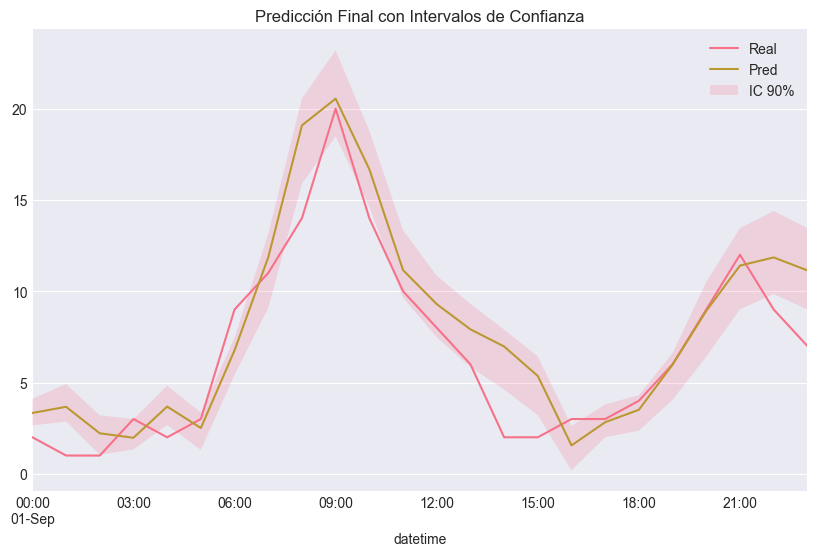

MAE: 1.763 | RMSE: 2.275


In [33]:
# Prediccion con el mejor modelo
print(len(X_pred))
pred = f_gbr_best_exog.predict(steps=HORIZON, exog=X_pred)
pred = pred.reindex(y_test.index)

# Intervalos de prediccion
f_gbr_best_exog.set_in_sample_residuals(y=y, exog=X)
pred_int = f_gbr_best_exog.predict_interval(steps=HORIZON, exog=X_pred, interval=[5, 95], n_boot=500, use_in_sample_residuals=True, random_state=42)
pred_int = pred_int.reindex(y_test.index)

# Mostramos los resultados de la prediccion y los intervalos
plt.figure(figsize=(10, 6))
y_test.plot(label="Real")
pred.plot(label="Pred")
plt.fill_between(pred_int.index, pred_int["lower_bound"], pred_int["upper_bound"], alpha=0.2, label="IC 90%")
plt.title("Predicción Final con Intervalos de Confianza")
plt.legend()
plt.show()
print(f"MAE: {mae(y_test, pred):.3f} | RMSE: {rmse(y_test, pred):.3f}")

Vemos que el gráfico para las siguientes 24 horas muestra un ajuste excelente a la dinámica real de la serie, la línea predicha sigue muy de cerca a la real, demostrando que el modelo ha aprendido con éxito la estacionalidad diaria. Además, el intervalo de confianza es estrecho, con la línea real manteniéndose casi completamente dentro de él, indicando que las predicciones son fiables y que la varianza del pronóstico es baja. Por último, las métricas finales son bajas, confirmando esta robustez. 